In [1]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import matplotlib.pyplot as plt
import os
config = dotenv_values(find_dotenv())
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

In [8]:
# import my merged data
data = pd.read_pickle(path_cleandata + 'BEA6_IOuse_merged.pkl')

In [9]:
# filter for the year 2017 
data2017 = data[data['date'].dt.year == 2017]

In [10]:
# personal consumption expenditures
data2017 = data2017[data2017['product_O'].str.contains('Personal consumption expenditures')][['product_I', 'date', 'IO_value', 'expenditures_I']]

In [11]:
# sum by product for that year
# first groupby: take sum of IO_value and mean of expenditures_I by date and product
byproduct = data2017.groupby(['product_I']).agg({
    'IO_value': 'mean',
    'expenditures_I': 'sum'}, min_count=1).reset_index()


## taking a look at how well the merge worked

In [12]:
# create distance variable
byproduct['distance'] = np.abs(byproduct['IO_value'] - byproduct['expenditures_I'])

# kinda "outliers" that have a very different value
outlier_threshold = 500000

# Filter only the points that are outliers
outliers = byproduct[byproduct['distance'] > outlier_threshold]

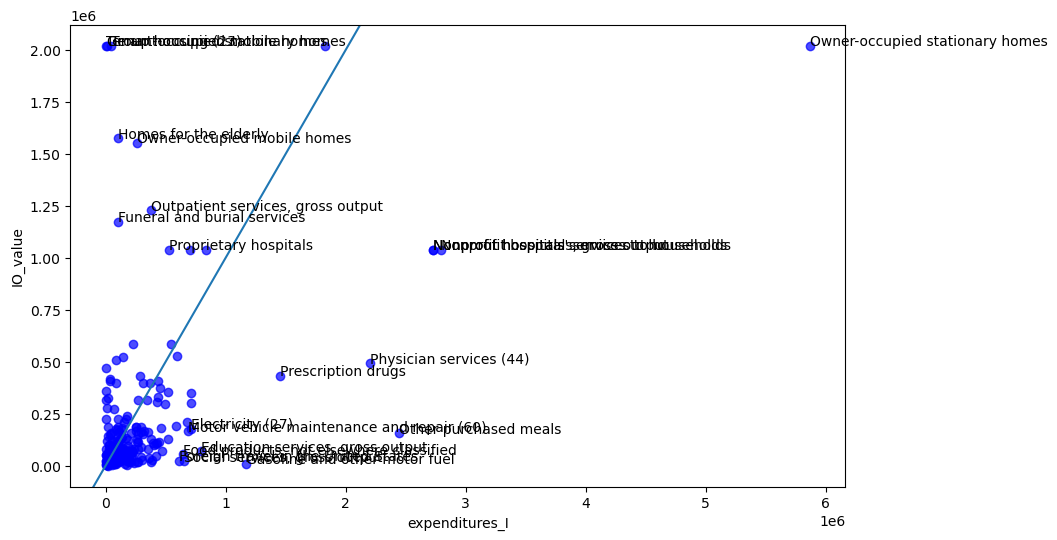

In [19]:
# do the scatter plot with expenditures on the x axis

plt.figure(figsize=(10, 6))
plt.scatter(byproduct['expenditures_I'], byproduct['IO_value'], c='blue', alpha=0.7)

plt.xlabel('expenditures_I')
plt.ylabel('IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

# annotations for outliers
for idx, row in outliers.iterrows():
    ax.annotate(row['product_I'].strip(), (row['expenditures_I'], row['IO_value']))

plt.savefig(path_figures + 'merge_check\\expenditures.pdf')

In [14]:
# this is the list of "outlier" products: issues mostly come from housing and healthcare type stuff
# noting the 2017 expenditures for tenant-occupied stationary houses is 0: having trouble getting min_count to work (actually all NaNs)
# within the merge, foreign travel in the United States gets matched with the rest-of-world adjustment in the IO table, which i should probably get rid of
outliers

,product_I,IO_value,expenditures_I,distance
16,Other purchased meals,156918.0,2447843.0,2290925.0
24,Tenant-occupied statio...,2020853.0,0.0,2020853.0
40,Electricity (27),177661.0,710644.0,532983.0
49,"Food products, not elsewhe...",55024.0,647815.0,592791.0
52,Foreign travel in the Unit...,23394.0,614049.0,590655.0
57,Homes for the elderly,1574526.0,102803.0,1471723.0
81,Nonprofit hospitals' servi...,1039196.0,2727424.0,1688228.0
90,Owner-occupied mobile homes,1553178.0,262852.0,1290326.0
91,Owner-occupied stationary ...,2020853.0,5870057.0,3849204.0
99,Prescription drugs,432930.0,1454682.0,1021752.0


In [20]:
# go into concordance, which shows some of the issues

concordance = pd.read_pickle(path_cleandata + 'concordance//concordance6_naics6.pkl')
outlierproducts = list(outliers['product_I'])

outliermerges = concordance[concordance['product'].isin(outlierproducts)]
outliermerges

# rest of the world adjustment needs to go (will just remove it within the data cleaning)
# for housing, only take the highest-similarity match (except for "homes for the elderly", which i should probably choose myself)
# social services matches dont really make sense...


,product,NAICS_desc,similarity
37,Owner-occupied stationary ...,Owner-occupied housing,0.833392
38,Owner-occupied stationary ...,Tenant-occupied housing,0.704807
44,Gasoline and other motor fuel,Motor vehicle gasoline engine and engine parts...,0.727025
54,"Food products, not elsewhe...",Snack food manufacturing,0.584398
55,"Food products, not elsewhe...",Other animal food manufacturing,0.573173
56,"Food products, not elsewhe...",Food and beverage stores,0.564792
60,Tenant-occupied mobile homes,Owner-occupied housing,0.737465
61,Tenant-occupied mobile homes,Tenant-occupied housing,0.807631
92,Owner-occupied mobile homes,Owner-occupied housing,0.766084
215,Homes for the elderly,Services to buildings and dwellings,0.560572


In [16]:
# for some reason min_count isnt working 
data2017[data2017['product_I'].str.contains('Tenant-occupied stationary homes')]

,product_I,date,IO_value,expenditures_I
1537397,Tenant-occupied statio...,2017-01-31,2020853.0,NaN
1537398,Tenant-occupied statio...,2017-04-30,2020853.0,NaN
1537399,Tenant-occupied statio...,2017-07-31,2020853.0,NaN
1537400,Tenant-occupied statio...,2017-10-31,2020853.0,NaN


In [17]:
# negative values for foreign travel?
data2017[data2017['product_I'].str.contains('Foreign travel')]

,product_I,date,IO_value,expenditures_I
3263373,Foreign travel in the Unit...,2017-01-31,23394.0,147206.0
3263374,Foreign travel in the Unit...,2017-04-30,23394.0,154816.0
3263375,Foreign travel in the Unit...,2017-07-31,23394.0,155366.0
3263376,Foreign travel in the Unit...,2017-10-31,23394.0,156661.0


c:\Users\EmilyFu\.conda\envs\myenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\EmilyFu\.conda\envs\myenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


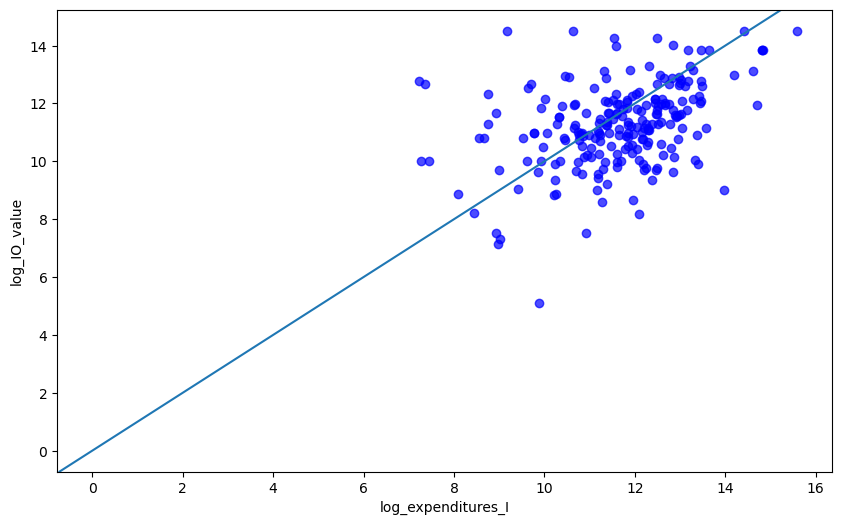

In [18]:
# get logs of everything and do an equivalent scatter plot with those

# do the scatter plot with expenditures on the x axis
plt.figure(figsize=(10, 6))
plt.scatter(np.log(byproduct['expenditures_I']), np.log(byproduct['IO_value']), c='blue', alpha=0.7)

plt.xlabel('log_expenditures_I')
plt.ylabel('log_IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

# plt.savefig(path_figures + 'merge_check\\log_expenditures.pdf')
